In [1]:
from sklearn import datasets
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

In [2]:
iris = datasets.load_iris()
features = iris.data 
target = iris.target

sepal_length = np.array(features[:, 0])
petal_width = np.array(features[:, 3])

species_names = list()

for i in target:
    if i == 0:
        species_names.append('setosa')
    elif i == 1:
        species_names.append('versicolor')
    else:
        species_names.append('virginica')

In [3]:
def predict(intercept, coefficient, x):
    return intercept + coefficient * x

def gd(x, y, epochs, df, alpha = 0.01):
    intercept, coefficient = 2.0, -7.5
    predictions = predict(intercept, coefficient, x)
    sum_error = np.sum((predictions - y) ** 2) / (2 * len(x))
    df.loc[0] = [intercept, coefficient, sum_error]
    for epoch in range(1, epochs):
        predictions = predict(intercept, coefficient, x)
        b0_error = (1/len(x)) * np.sum(predictions - y)
        b1_error = (1/len(x)) * np.sum((predictions - y) * x)
        intercept = intercept - alpha * b0_error
        coefficient = coefficient - alpha * b1_error 
        sum_error = np.sum((predictions - y) ** 2) / (2 * len(x))
        df.loc[epoch] = [intercept, coefficient, sum_error]
        sum_error = 0
    return df

def sgd(x, y, epochs, df, alpha = 0.01):
    intercept = 2.0
    coefficient = -7.5
    sum_error = 0
    
    index = np.random.randint(0, len(x))
    prediction = predict(intercept, coefficient, x[index])
    sum_error = sum_error + (((prediction - y[index]) ** 2) / 2)
    df.loc[0] = [intercept, coefficient, sum_error]

    for i in range(1,epochs):
        # get random index
        index = np.random.randint(0, len(x))
        # get random x and y
        x_i, y_i = x[index], y[index]
        # get prediction
        prediction = predict(intercept, coefficient, x_i)
        b0_error = prediction - y_i
        b1_error = (prediction - y_i) * x_i

        intercept = intercept - alpha * b0_error
        coefficient = coefficient - alpha * b1_error 

        sum_error = (((prediction - y_i) ** 2) / 2)
        df.loc[i] = [intercept, coefficient, sum_error]
    return df

In [4]:
epochs = 5000
total = epochs - 1
half = int(epochs / 2) - 1
quarter = int(epochs / 4) - 1

sgd_loss = pd.DataFrame(columns=['intercept', 'coefficient', 'sum_error'])
sgd_loss = sgd(sepal_length, petal_width, epochs = epochs, df = sgd_loss)

In [8]:
gd_loss = pd.DataFrame(columns=['intercept', 'coefficient', 'sum_error'])
gd_loss = gd(sepal_length, petal_width, epochs = epochs, df = gd_loss)

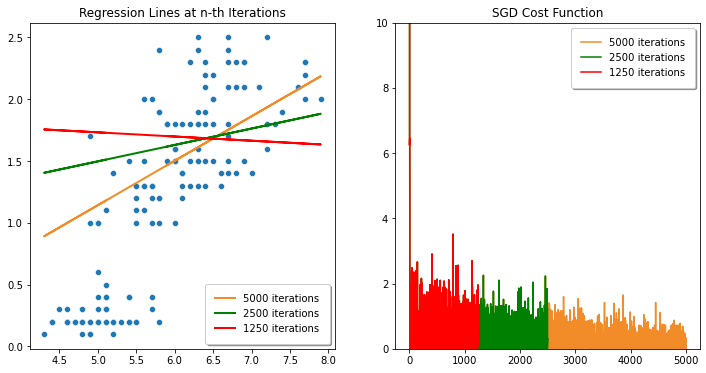

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# SGD regression line plot
sns.scatterplot(x=sepal_length, y=petal_width, data=iris, ax=ax[0])

iterations = [total, half, quarter]
colors = ['#f28c28', 'g', 'r']

for iteration, color in zip(iterations, colors):
    ax[0].plot(
        sepal_length, 
        sgd_loss['intercept'][iteration] + sgd_loss['coefficient'][iteration] * sepal_length,
        color = color,
        linewidth = 2,
        label = f'{iteration + 1} iterations'
    )
ax[0].set_title("Regression Lines at n-th Iterations")
ax[0].legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

# SGD cost function plot
for iteration, color in zip(iterations, colors):
    ax[1].plot(
        np.arange(0, iteration), 
        sgd_loss['sum_error'][:iteration], 
        color = color, 
        label = f'{iteration+1} iterations'
    )
ax[1].set_title(f'SGD Cost Function')
ax[1].set_ylim(0, 10.0)
ax[1].legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

In [10]:
# generate a mean squared error contour surface
intercepts = np.linspace(-10, 10, 10)
coefficients = np.linspace(-10, 10, 10)
x, y = np.meshgrid(intercepts, coefficients)
z = np.zeros(x.shape)
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        z[i, j] = mean_squared_error(predict(x[i, j], y[i, j], sepal_length), petal_width)

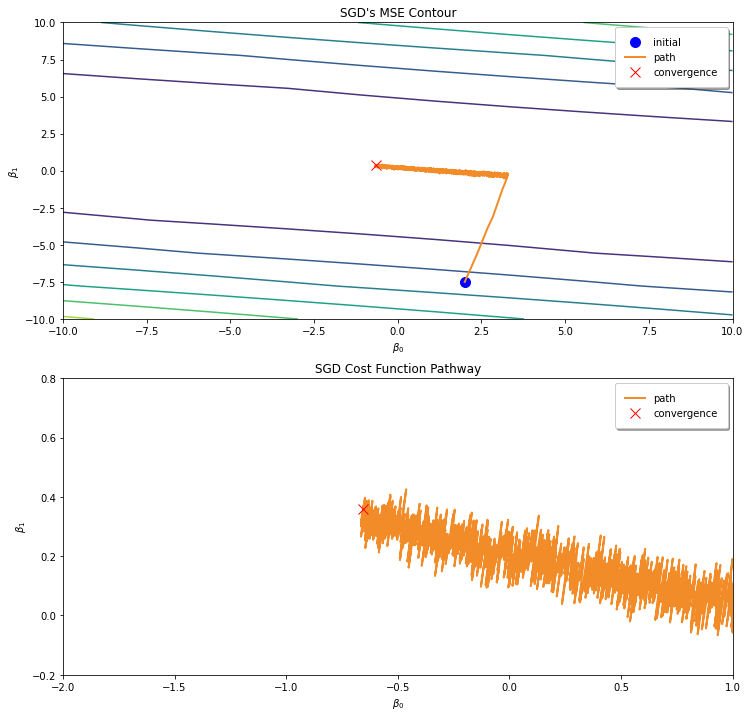

In [11]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

ax[0].contour(x, y, z)
ax[0].set_title("SGD's MSE Contour")
ax[0].set_xlabel(r'$\beta_0$')
ax[0].set_ylabel(r'$\beta_1$')
ax[0].plot(sgd_loss['intercept'][0], sgd_loss['coefficient'][0], "o", markersize=10, color="blue", label="initial")
ax[0].plot(sgd_loss['intercept'][0:len(sgd_loss)-2], sgd_loss['coefficient'][0:len(sgd_loss)-2], color="#f28c28", linewidth=2, label="path")
ax[0].plot(sgd_loss['intercept'][len(sgd_loss)-1], sgd_loss['coefficient'][len(sgd_loss)-1], 'x', markersize=10, color='red', label="convergence")
ax[0].legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

ax[1].contour(x, y, z)
ax[1].set_title("SGD Cost Function Pathway")
ax[1].set_xlabel(r'$\beta_0$')
ax[1].set_ylabel(r'$\beta_1$')
ax[1].plot(sgd_loss['intercept'][0:len(sgd_loss)-2], sgd_loss['coefficient'][0:len(sgd_loss)-2], color="#f28c28", linewidth=2, label="path")
ax[1].plot(sgd_loss['intercept'][len(sgd_loss)-1], sgd_loss['coefficient'][len(sgd_loss)-1], 'x', markersize=10, color='red', label="convergence")
ax[1].set_xlim(-2.0, 1.0)
ax[1].set_ylim(-0.2, 0.8)
ax[1].legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

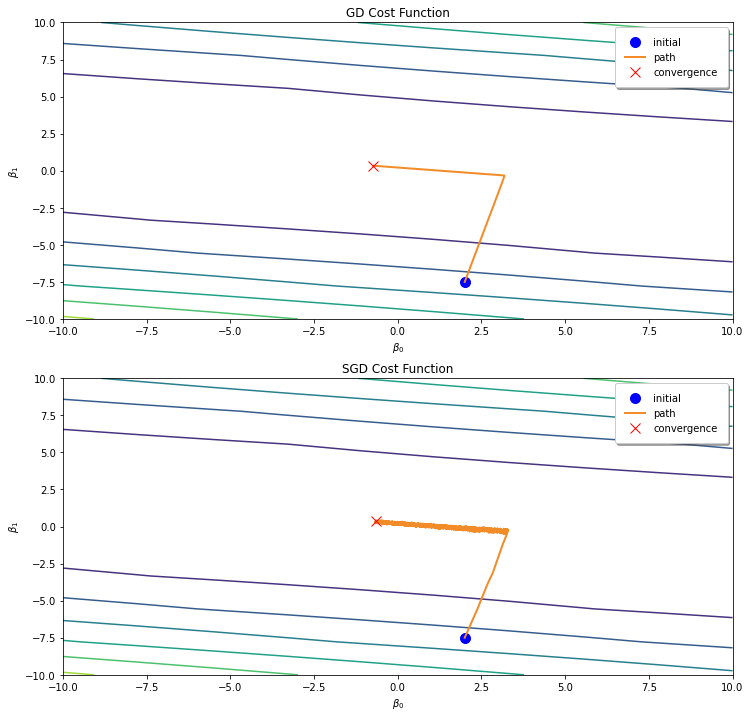

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

# for gd
ax[0].contour(x, y, z)
ax[0].set_title("GD Cost Function")
ax[0].set_xlabel(r'$\beta_0$')
ax[0].set_ylabel(r'$\beta_1$')
ax[0].plot(gd_loss['intercept'][0], gd_loss['coefficient'][0], "o", markersize=10, color="blue", label="initial")
ax[0].plot(gd_loss['intercept'][0:len(gd_loss)-2], gd_loss['coefficient'][0:len(gd_loss)-2], color="#f28c28", linewidth=2, label="path")
ax[0].plot(gd_loss['intercept'][len(gd_loss)-1], gd_loss['coefficient'][len(gd_loss)-1], 'x', markersize=10, color='red', label="convergence")
ax[0].legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

ax[1].contour(x, y, z)
ax[1].set_title("SGD Cost Function")
ax[1].set_xlabel(r'$\beta_0$')
ax[1].set_ylabel(r'$\beta_1$')
ax[1].plot(sgd_loss['intercept'][0], sgd_loss['coefficient'][0], "o", markersize=10, color="blue", label="initial")
ax[1].plot(sgd_loss['intercept'][0:len(sgd_loss)-2], sgd_loss['coefficient'][0:len(sgd_loss)-2], color="#f28c28", linewidth=2, label="path")
ax[1].plot(sgd_loss['intercept'][len(sgd_loss)-1], sgd_loss['coefficient'][len(sgd_loss)-1], 'x', markersize=10, color='red', label="convergence")
ax[1].legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

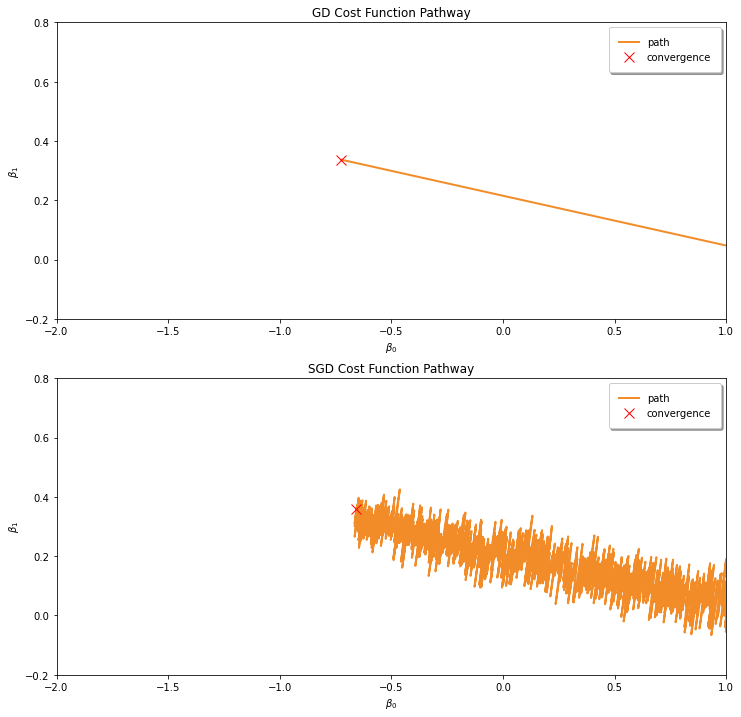

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(12, 12))

ax[0].contour(x, y, z)
ax[0].set_title("GD Cost Function Pathway")
ax[0].set_xlabel(r'$\beta_0$')
ax[0].set_ylabel(r'$\beta_1$')
ax[0].plot(gd_loss['intercept'][0:len(gd_loss)-2], gd_loss['coefficient'][0:len(gd_loss)-2], color="#f28c28", linewidth=2, label="path")
ax[0].plot(gd_loss['intercept'][len(gd_loss)-1], gd_loss['coefficient'][len(gd_loss)-1], 'x', markersize=10, color='red', label="convergence")
ax[0].set_xlim(-2.0, 1.0)
ax[0].set_ylim(-0.2, 0.8)
ax[0].legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)

ax[1].contour(x, y, z)
ax[1].set_title("SGD Cost Function Pathway")
ax[1].set_xlabel(r'$\beta_0$')
ax[1].set_ylabel(r'$\beta_1$')
ax[1].plot(sgd_loss['intercept'][0:len(sgd_loss)-2], sgd_loss['coefficient'][0:len(sgd_loss)-2], color="#f28c28", linewidth=2, label="path")
ax[1].plot(sgd_loss['intercept'][len(sgd_loss)-1], sgd_loss['coefficient'][len(sgd_loss)-1], 'x', markersize=10, color='red', label="convergence")
ax[1].set_xlim(-2.0, 1.0)
ax[1].set_ylim(-0.2, 0.8)
ax[1].legend(fancybox=True, framealpha=1, shadow=True, borderpad=1)